# Estimating functional relationship

This notebook details the method train(), which estimates the functional relationship between variables.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creating test data
Create test data with variables from x0 to x5, of which x2 is a categorical variable.

### Causal graph

array([[0. , 0. , 0. , 3. , 0. , 0. ],
       [3. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [8. , 0. , 1. , 0. , 0. , 0. ],
       [4. , 0. , 0. , 0. , 0. , 0. ]])

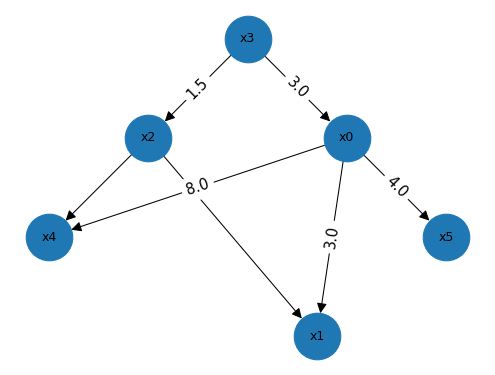

### Test data

,x0,x1,x2,x3,x4,x5
0,2.457959,3.979581,b,0.548814,10.245798,10.198616
1,2.621652,8.431475,a,0.715189,21.602835,10.784233
2,2.331446,7.131753,a,0.602763,19.430153,9.394384
3,1.885170,3.177467,b,0.544883,8.392238,7.893208
4,1.876007,5.681239,a,0.423655,15.824472,7.736226
...,...,...,...,...,...,...
995,1.234716,2.070230,b,0.097676,5.288504,5.043098
996,2.090899,3.371803,b,0.514922,8.798471,8.503125
997,3.138850,9.613938,a,0.938412,25.940801,13.251922
998,1.499485,2.647914,b,0.228647,6.930745,6.481635


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

display(G)

graph = nx.DiGraph()

graph.add_node("x0", pos=(3, 1))
graph.add_node("x1", pos=(2.7, -1))
graph.add_node("x2", pos=(1, 1))
graph.add_node("x3", pos=(2, 2))
graph.add_node("x4", pos=(0, 0))
graph.add_node("x5", pos=(4, 0))

edges = []
edge_labels = {}
for to, from_ in np.argwhere(~np.isclose(G, 0)):
    edges.append((f"x{from_}", f"x{to}"))
    if from_ == 2:
        continue
    edge_labels[(f"x{to}", f"x{from_}")] = G[to, from_]
graph.add_edges_from(edges)
pos = nx.get_node_attributes(graph, "pos")
nx.draw(graph, pos, with_labels=True, arrowsize=20, node_size=2000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
plt.show() 

display(Markdown("### Test data"))

N = 1000

X = {}

X["x3"] = np.random.uniform(size=N)

X["x2"] = np.empty(N).astype(str)
for i in range(N):
    prob_a = expit(G[2, 3] * X["x3"][i] - 0.5)
    X["x2"][i] = np.random.choice(["a", "b"], p=[prob_a, 1 - prob_a])

X["x0"] = G[0, 3] * X["x3"] + np.random.uniform(size=N)

X["x4"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x4"][i] = 8.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x4"][i] = 4.0 * X["x0"][i] + np.random.uniform()

X["x1"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x1"][i] = 3.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x1"][i] = 1.5 * X["x0"][i] + np.random.uniform()

X["x5"] = G[5, 0] * X["x0"] + np.random.uniform(size=1000)

X = pd.DataFrame(X)
X["x2"] = X["x2"].astype("category")
X = X[sorted(X.columns)]

display(X)

## Estimate functional relationship between variables

By executing train() given test data and a causal graph, the functional relationship between each variable in the test data can be estimated. The model representing the functional relationship of each variable can be specified in the models argument. If not specified, a linear or logistic regression model is used by default.

The explanatory variables used for the model representing the functional relationship are determined by analyzing the causal graph in train(). To train each model, a column of explanatory and objective variables is taken from the given *X* and used. The most upstream variables do not have models.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G)

You can check *sim.train_result_* for the estimated model and a list of variables that are inputs to the estimated model. *train_reuslt_* is a dictionary whose keys are variable names. Let's check the actual contents of *train_result_*.

In [4]:
display(Markdown("### List of variables"))
print(sim.train_result_.keys())

display(Markdown("### Length of estimated result for x1"))
print(type(sim.train_result_["x1"]), len(sim.train_result_["x1"]))

### List of variables

dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])


### Length of estimated result for x1

<class 'list'> 2


The values corresponding to *train_result_["x1"]* is a list. If a parent is a categorical variable, there is a child model for every possible value the parent can take. Since the parent *x2* takes the value a or b, the child *x1* will have two models, which together constitute a list of length 2 for *train_result_["x1"]*.

### Contents of the list of estimated results for x1

For each parent value, we have an instance *model* of the machine learning model, a list of variable names *exp_columns* that served as explanatory variables for the machine learning model, a prediction *predicted* for the training data, and *residual* for the prediction on the training data. In addition, the values of the conditional parents are stored in *condition*.

### Information about the estimated functional relationship

dict_keys(['condition', 'model', 'exp_columns', 'predicted', 'residual'])


### Condition

{'x2': 'a'}
{'x2': 'b'}


### Machine learning model

LinearRegression() [3.001] 0.4948594354078173
LinearRegression() [1.484] 0.5067806444646545


### Explanatory

['x0']
['x0']


### Prediction for training data

shape of x1 given x0=a (539,)
shape of x1 given x0=b (461,)


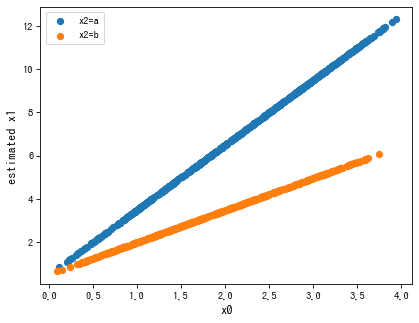

### Residual of training

shape of x1 given x2=a (539,)
shape of x1 given x2=b (461,)


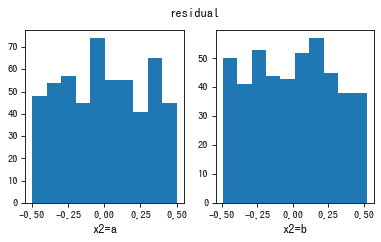

In [5]:
display(Markdown("### Information about the estimated functional relationship"))
print(sim.train_result_["x1"][0].keys())

display(Markdown("### Condition"))
print(sim.train_result_["x1"][0]["condition"])
print(sim.train_result_["x1"][1]["condition"])

display(Markdown("### Machine learning model"))
model = sim.train_result_["x1"][0]["model"]
print(model, model.coef_, model.intercept_)
model = sim.train_result_["x1"][1]["model"]
print(model, model.coef_, model.intercept_)

display(Markdown("### Explanatory"))
print(sim.train_result_["x1"][0]["exp_columns"])
print(sim.train_result_["x1"][1]["exp_columns"])

display(Markdown("### Prediction for training data"))
print("shape of x1 given x0=a", sim.train_result_["x1"][0]["predicted"].shape)
print("shape of x1 given x0=b", sim.train_result_["x1"][1]["predicted"].shape)

predicted = sim.train_result_["x1"][0]["predicted"]
plt.scatter(X["x0"].loc[predicted.index], predicted, label="x2=a")
predicted = sim.train_result_["x1"][1]["predicted"]
plt.scatter(X["x0"].loc[predicted.index], predicted, label="x2=b")
plt.legend()
plt.xlabel("x0")
plt.ylabel("estimated x1")
plt.show()

display(Markdown("### Residual of training"))
print("shape of x1 given x2=a", sim.train_result_["x1"][0]["residual"].shape)
print("shape of x1 given x2=b", sim.train_result_["x1"][1]["residual"].shape)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
residual = sim.train_result_["x1"][0]["residual"]
axes[0].hist(residual)
axes[0].set_xlabel("x2=a")
residual = sim.train_result_["x1"][1]["residual"]
axes[1].hist(residual)
axes[1].set_xlabel("x2=b")
plt.suptitle("residual")
plt.show()

We introduced the case where the parent is a categorical variable, but if the parents are not categorical, a list of length 1 is stored as the value of *train_result_*, as shown below. In such a case, the condition is also None.

In [6]:
print(len(sim.train_result_["x0"]))
print(sim.train_result_["x0"][0]["condition"])

1
None


The residuals are as follows. The most upstream, x3, and categorical variables, x2, are NaN because they do not have residuals.

In [7]:
sim.residual_.head()

,x0,x1,x2,x3,x4,x5
0,0.307648,-0.174462,NaN,NaN,-0.057256,-0.125786
1,-0.022822,0.068330,NaN,NaN,0.142083,-0.194651
2,0.020896,-0.360406,NaN,NaN,0.292654,-0.424192
3,-0.253467,-0.126638,NaN,NaN,0.370783,-0.141057
4,0.097439,-0.444025,NaN,NaN,0.333002,-0.261405


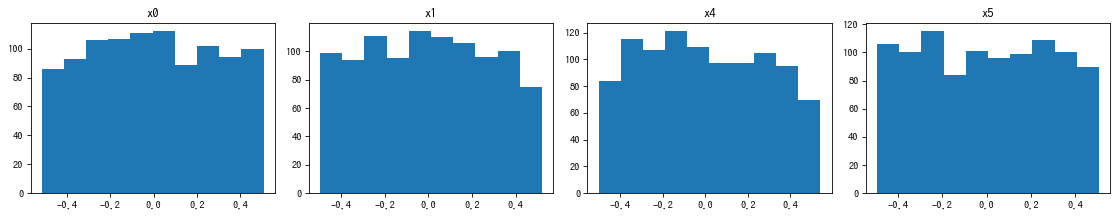

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, key in enumerate(["x0", "x1", "x4", "x5"]):
    series = sim.residual_[key]
    axes[i].hist(series)
    axes[i].set_title(key)
plt.tight_layout()
plt.show()

## Estimate functional relationship between variables by specifying a model

The functional relationship between variables is estimated by default using linear regression when the objective variable is a non-categorical variable and logistic regression when it is a categorical variable, but another machine learning model can be used by using the *models* option. Here we set up *x1* to apply the random forest regression model as the model.

In [9]:
models = {
    "x1": RandomForestRegressor(),
}

sim = CausalBasedSimulator()
sim.train(X, G, models=models)

print(sim.train_result_["x1"][0]["model"])
print(sim.train_result_["x1"][1]["model"])

RandomForestRegressor()
RandomForestRegressor()


We can confirm that the model for *x1" is a random forest regression model for both *x0=a* and *x0=b*.
Although the models are given only one machine learning instance for *x1*, CausalBasedSImulator clones instances for each condition and then train each instance.

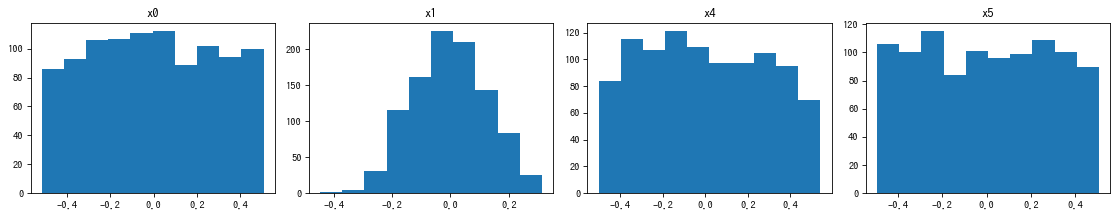

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, key in enumerate(["x0", "x1", "x4", "x5"]):
    series = sim.residual_[key]
    axes[i].hist(series)
    axes[i].set_title(key)
plt.tight_layout()
plt.show()

We can see that the residuals have changed from before the model change.

## Configurable models

We have just set up a random forest regression model and a random forest classification model, but you can also set up other scikit-learn regression/classification models, Pipeline, GridSearchCV, etc.

In [11]:
# Pipeline
models = {
    "x1": Pipeline([
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression())
    ])
}

sim = CausalBasedSimulator()
sim.train(X, G, models=models)

scaler = sim.train_result_["x1"][0]["model"]["scaler"]
print(scaler, scaler.mean_, scaler.var_)
estimator = sim.train_result_["x1"][0]["model"]["estimator"]
print(estimator, estimator.coef_, estimator.intercept_)

scaler = sim.train_result_["x1"][1]["model"]["scaler"]
print(scaler, scaler.mean_, scaler.var_)
estimator = sim.train_result_["x1"][1]["model"]["estimator"]
print(estimator, estimator.coef_, estimator.intercept_)

StandardScaler() [2.159] [0.836]
LinearRegression() [2.744] 6.973555147612068
StandardScaler() [1.8] [0.748]
LinearRegression() [1.283] 3.1774015657438124


In [12]:
# GridSearchCV
models = {
    "x1": GridSearchCV(
        SVR(),
        {
            "C": [1e-2, 1e-0, 1e+2],
            "gamma": [1e-2, 1e-0, 1e+2],
        }
    )
}

sim = CausalBasedSimulator()
sim.train(X, G, models=models)

estimator = sim.train_result_["x1"][0]["model"]
print(estimator.best_params_)

estimator = sim.train_result_["x1"][1]["model"]
print(estimator.best_params_)

{'C': 100.0, 'gamma': 0.01}
{'C': 100.0, 'gamma': 0.01}
